In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import time
from spn_3.spn import SPN
from utils import train, count_parameters, apply_lth_pruning, clean_weights, merge_weights

In [2]:
# Set the seed for PyTorch (CPU and GPU)
torch.manual_seed(42)

torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
#hyperparameters
batch_size = 32
learning_rate = 0.01
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Get Dataset

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load Titanic dataset (assuming it's saved locally as 'titanic.csv')
df = pd.read_csv('data/Titanic-Dataset.csv')

# Preprocess Data (fill missing values, encode categorical variables)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Convert 'Sex' to binary (male = 0, female = 1)
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

# Convert 'Embarked' to numeric
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

# Drop columns not needed for prediction
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# Separate features and target
X = df.drop('Survived', axis=1).values
y = df['Survived'].values

/tmp/ipykernel_2980764/1233603349.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipykernel_2980764/1233603349.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [5]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Minimal MLP

In [7]:
class Minimal_MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, num_classes):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

MLP baseline

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_dims, num_classes):
        super().__init__()
        layers = []
        prev_dim = input_size
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.ReLU())
            prev_dim = hdim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [9]:
num_classes = 2
MLP_hidden_dims = [64, 32]
total_nodes = sum(MLP_hidden_dims)
input_size = X_train.shape[1]
num_samples = X_train.shape[0]

In [10]:
model_0 = Minimal_MLP(input_size, sum(MLP_hidden_dims), num_classes).cuda()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.SGD(model_0.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
param_count_0 = count_parameters(model_0)

In [13]:
train_metrics_0, val_metrics_0 = train(model_0, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.0174 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.6517 Train_Loss: 0.6064 Validation_Accuracy: 0.8045 Validation_Loss: 0.4678
Epoch: 2 Total_Time: 0.0206 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.7978 Train_Loss: 0.4612 Validation_Accuracy: 0.8045 Validation_Loss: 0.4292
Epoch: 3 Total_Time: 0.0119 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8132 Train_Loss: 0.4456 Validation_Accuracy: 0.7989 Validation_Loss: 0.4214
Epoch: 4 Total_Time: 0.0114 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8146 Train_Loss: 0.4353 Validation_Accuracy: 0.8045 Validation_Loss: 0.4167
Epoch: 5 Total_Time: 0.0114 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8216 Train_Loss: 0.4291 Validation_Accuracy: 0.8156 Validation_Loss: 0.4042
Epoch: 6 Total_Time: 0.0114 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8244 Train_Loss: 0.4228 Validation_Accuracy: 0.8101 Validation_Loss: 0.4018
Epoch: 7 Total_Time: 0.0113 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8076

In [14]:
model_1 = MLP(input_size, MLP_hidden_dims, num_classes).to(device)

In [15]:
# Optimizer (Stochastic Gradient Descent with momentum)
optimizer = optim.SGD(model_1.parameters(), lr=learning_rate, momentum=0.9)

In [16]:
param_count_1 = count_parameters(model_1)

In [17]:
train_metrics_1, val_metrics_1 = train(model_1, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.0151 Average_Time_per_batch: 0.0007 Train_Accuracy: 0.5702 Train_Loss: 0.6704 Validation_Accuracy: 0.5866 Validation_Loss: 0.6222
Epoch: 2 Total_Time: 0.0159 Average_Time_per_batch: 0.0007 Train_Accuracy: 0.6671 Train_Loss: 0.5766 Validation_Accuracy: 0.7877 Validation_Loss: 0.5313
Epoch: 3 Total_Time: 0.0167 Average_Time_per_batch: 0.0007 Train_Accuracy: 0.7879 Train_Loss: 0.4974 Validation_Accuracy: 0.7877 Validation_Loss: 0.4568
Epoch: 4 Total_Time: 0.0183 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.8020 Train_Loss: 0.4544 Validation_Accuracy: 0.8045 Validation_Loss: 0.4316
Epoch: 5 Total_Time: 0.0144 Average_Time_per_batch: 0.0006 Train_Accuracy: 0.7978 Train_Loss: 0.4394 Validation_Accuracy: 0.8045 Validation_Loss: 0.4267
Epoch: 6 Total_Time: 0.0145 Average_Time_per_batch: 0.0006 Train_Accuracy: 0.8076 Train_Loss: 0.4304 Validation_Accuracy: 0.8045 Validation_Loss: 0.4264
Epoch: 7 Total_Time: 0.0145 Average_Time_per_batch: 0.0006 Train_Accuracy: 0.8118

Minimal SPN

In [18]:
model_2 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes).cuda()
optimizer = optim.SGD(model_2.parameters(), lr=learning_rate, momentum=0.9)

In [19]:
param_count_2 = model_2.count_parameters()

In [20]:
train_metrics_2, val_metrics_2 = train(model_2, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.0127 Average_Time_per_batch: 0.0006 Train_Accuracy: 0.8062 Train_Loss: 0.5164 Validation_Accuracy: 0.7821 Validation_Loss: 0.4310
Epoch: 2 Total_Time: 0.0122 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8034 Train_Loss: 0.4425 Validation_Accuracy: 0.8101 Validation_Loss: 0.4270
Epoch: 3 Total_Time: 0.0122 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8146 Train_Loss: 0.4369 Validation_Accuracy: 0.8045 Validation_Loss: 0.4270
Epoch: 4 Total_Time: 0.0122 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8104 Train_Loss: 0.4319 Validation_Accuracy: 0.8045 Validation_Loss: 0.4161
Epoch: 5 Total_Time: 0.0123 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8216 Train_Loss: 0.4253 Validation_Accuracy: 0.8156 Validation_Loss: 0.4247
Epoch: 6 Total_Time: 0.0122 Average_Time_per_batch: 0.0005 Train_Accuracy: 0.8202 Train_Loss: 0.4209 Validation_Accuracy: 0.8045 Validation_Loss: 0.4181
Epoch: 7 Total_Time: 0.0128 Average_Time_per_batch: 0.0006 Train_Accuracy: 0.8216

Maximal SPN

In [21]:
model_3 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.SGD(model_3.parameters(), lr=learning_rate, momentum=0.9)

In [22]:
param_count_3 = model_3.count_parameters()

In [23]:
train_metrics_3, val_metrics_3 = train(model_3, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.3714 Average_Time_per_batch: 0.0161 Train_Accuracy: 0.7430 Train_Loss: 0.5709 Validation_Accuracy: 0.7933 Validation_Loss: 0.4682
Epoch: 2 Total_Time: 0.3522 Average_Time_per_batch: 0.0153 Train_Accuracy: 0.7949 Train_Loss: 0.4633 Validation_Accuracy: 0.7933 Validation_Loss: 0.4263
Epoch: 3 Total_Time: 0.3695 Average_Time_per_batch: 0.0161 Train_Accuracy: 0.8146 Train_Loss: 0.4467 Validation_Accuracy: 0.7989 Validation_Loss: 0.4225
Epoch: 4 Total_Time: 0.3798 Average_Time_per_batch: 0.0165 Train_Accuracy: 0.8090 Train_Loss: 0.4438 Validation_Accuracy: 0.7989 Validation_Loss: 0.4163
Epoch: 5 Total_Time: 0.3747 Average_Time_per_batch: 0.0163 Train_Accuracy: 0.8034 Train_Loss: 0.4423 Validation_Accuracy: 0.8045 Validation_Loss: 0.4145
Epoch: 6 Total_Time: 0.3967 Average_Time_per_batch: 0.0172 Train_Accuracy: 0.8118 Train_Loss: 0.4388 Validation_Accuracy: 0.7989 Validation_Loss: 0.4136
Epoch: 7 Total_Time: 0.3761 Average_Time_per_batch: 0.0164 Train_Accuracy: 0.8132

Free Weights SPN

In [24]:
model_4 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False, hidden_dims = MLP_hidden_dims + [num_classes]).cuda()
optimizer = optim.SGD(model_4.parameters(), lr=learning_rate, momentum=0.9)

In [25]:
param_count_4 = model_4.count_parameters()

In [26]:
train_metrics_4, val_metrics_4 = train(model_4, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.0432 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.7626 Train_Loss: 0.5401 Validation_Accuracy: 0.7765 Validation_Loss: 0.4447
Epoch: 2 Total_Time: 0.0327 Average_Time_per_batch: 0.0014 Train_Accuracy: 0.7978 Train_Loss: 0.4593 Validation_Accuracy: 0.7989 Validation_Loss: 0.4214
Epoch: 3 Total_Time: 0.0180 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.8104 Train_Loss: 0.4481 Validation_Accuracy: 0.8045 Validation_Loss: 0.4243
Epoch: 4 Total_Time: 0.0180 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.8020 Train_Loss: 0.4472 Validation_Accuracy: 0.7933 Validation_Loss: 0.4189


Epoch: 5 Total_Time: 0.0212 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.7992 Train_Loss: 0.4431 Validation_Accuracy: 0.7989 Validation_Loss: 0.4153
Epoch: 6 Total_Time: 0.0214 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.8048 Train_Loss: 0.4402 Validation_Accuracy: 0.7989 Validation_Loss: 0.4183
Epoch: 7 Total_Time: 0.0193 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.8090 Train_Loss: 0.4381 Validation_Accuracy: 0.8045 Validation_Loss: 0.4108
Epoch: 8 Total_Time: 0.0192 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.8034 Train_Loss: 0.4338 Validation_Accuracy: 0.8045 Validation_Loss: 0.4169
Epoch: 9 Total_Time: 0.0191 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.8132 Train_Loss: 0.4291 Validation_Accuracy: 0.7989 Validation_Loss: 0.4111
Epoch: 10 Total_Time: 0.0191 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.8174 Train_Loss: 0.4265 Validation_Accuracy: 0.8101 Validation_Loss: 0.4131
Epoch: 11 Total_Time: 0.0216 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.81

Maximal SPN with pruning

In [27]:
model_5 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.SGD(model_5.parameters(), lr=learning_rate, momentum=0.9)

In [28]:
percent = 0.95
rounds = 10
pruning_epochs = 1

pruning_start = time.time()
new_weights = apply_lth_pruning(model_5, train_loader, test_loader, pruning_epochs, optimizer, criterion, percent, rounds)
pruning_time = time.time() - pruning_start

Initial Validation Phase
Epoch: 1 Total_Time: 0.3586 Average_Time_per_batch: 0.0156 Train_Accuracy: 0.6025 Train_Loss: 0.6394 Validation_Accuracy: 0.7598 Validation_Loss: 0.4839

Pruning Round: 1
Epoch: 1 Total_Time: 0.3656 Average_Time_per_batch: 0.0159 Train_Accuracy: 0.7261 Train_Loss: 0.5618 Validation_Accuracy: 0.7821 Validation_Loss: 0.4561

Pruning Round: 2
Epoch: 1 Total_Time: 0.3497 Average_Time_per_batch: 0.0152 Train_Accuracy: 0.7303 Train_Loss: 0.5550 Validation_Accuracy: 0.7933 Validation_Loss: 0.4444

Pruning Round: 3
Epoch: 1 Total_Time: 0.3668 Average_Time_per_batch: 0.0159 Train_Accuracy: 0.7331 Train_Loss: 0.5567 Validation_Accuracy: 0.7877 Validation_Loss: 0.4529

Pruning Round: 4
Epoch: 1 Total_Time: 0.3564 Average_Time_per_batch: 0.0155 Train_Accuracy: 0.7275 Train_Loss: 0.5651 Validation_Accuracy: 0.7821 Validation_Loss: 0.4588

Pruning Round: 5
Epoch: 1 Total_Time: 0.3508 Average_Time_per_batch: 0.0153 Train_Accuracy: 0.7219 Train_Loss: 0.5633 Validation_Accuracy

In [29]:
cleaned_weights = clean_weights(new_weights, input_size)
merged_weights = merge_weights(cleaned_weights, input_size, num_classes)

Empty Blocks:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
Empty Blocks:  [8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22]
Empty Blocks:  []


In [30]:
hidden_dims_pruned = [weight.shape[0] for weight in merged_weights]
print("Pruned Dimensions: ", hidden_dims_pruned)
print("Pruning Time: ", pruning_time)

Pruned Dimensions:  [2, 2]
Pruning Time:  4.938861608505249


In [31]:
model_5 = SPN(input_size, sum(hidden_dims_pruned), num_classes, minimal=False, hidden_dims=hidden_dims_pruned).cuda()
optimizer = optim.SGD(model_5.parameters(), lr=learning_rate, momentum=0.9)

In [32]:
param_count_5 = model_5.count_parameters()

In [33]:
train_metrics_5, val_metrics_5 = train(model_5, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 0.0151 Average_Time_per_batch: 0.0007 Train_Accuracy: 0.6798 Train_Loss: 0.6769 Validation_Accuracy: 0.7709 Validation_Loss: 0.4990
Epoch: 2 Total_Time: 0.0145 Average_Time_per_batch: 0.0006 Train_Accuracy: 0.7781 Train_Loss: 0.4824 Validation_Accuracy: 0.7933 Validation_Loss: 0.4420
Epoch: 3 Total_Time: 0.0144 Average_Time_per_batch: 0.0006 Train_Accuracy: 0.8006 Train_Loss: 0.4522 Validation_Accuracy: 0.7933 Validation_Loss: 0.4322
Epoch: 4 Total_Time: 0.0145 Average_Time_per_batch: 0.0006 Train_Accuracy: 0.8118 Train_Loss: 0.4475 Validation_Accuracy: 0.7933 Validation_Loss: 0.4292
Epoch: 5 Total_Time: 0.0157 Average_Time_per_batch: 0.0007 Train_Accuracy: 0.8020 Train_Loss: 0.4450 Validation_Accuracy: 0.7989 Validation_Loss: 0.4240
Epoch: 6 Total_Time: 0.0154 Average_Time_per_batch: 0.0007 Train_Accuracy: 0.8006 Train_Loss: 0.4436 Validation_Accuracy: 0.8045 Validation_Loss: 0.4233
Epoch: 7 Total_Time: 0.0145 Average_Time_per_batch: 0.0006 Train_Accuracy: 0.8076

Plot Training and Test Accuracies Across Epochs

In [34]:
import matplotlib.pyplot as plt
import numpy as np

train_acc_0 = train_metrics_0[:, 2] / (num_samples / batch_size)
train_acc_1 = train_metrics_1[:, 2] / (num_samples / batch_size)
train_acc_2 = train_metrics_2[:, 2] / (num_samples / batch_size)
train_acc_3 = train_metrics_3[:, 2] / (num_samples / batch_size)
train_acc_4 = train_metrics_4[:, 2] / (num_samples / batch_size)
train_acc_5 = train_metrics_5[:, 2] / (num_samples / batch_size)

epochs = np.arange(1, epochs + 1)

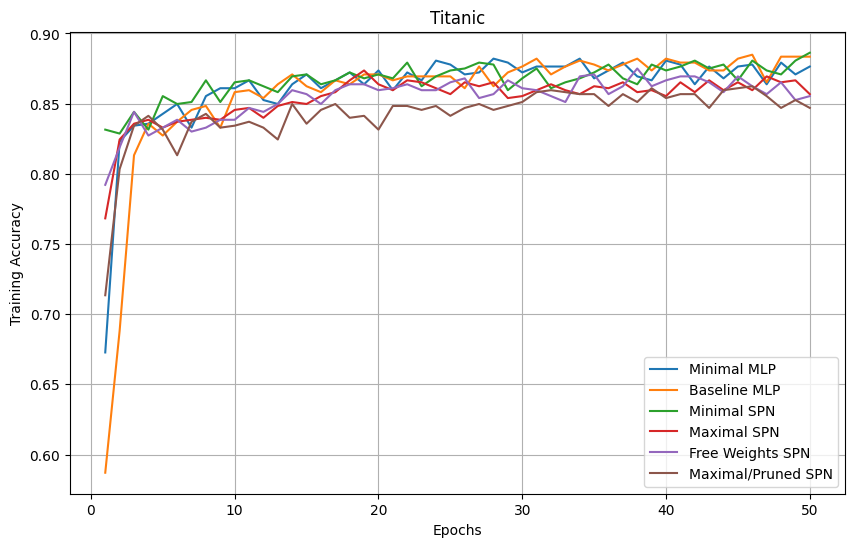

In [35]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_acc_0, label='Minimal MLP')
plt.plot(epochs, train_acc_1, label='Baseline MLP')
plt.plot(epochs, train_acc_2, label='Minimal SPN')
plt.plot(epochs, train_acc_3, label='Maximal SPN')
plt.plot(epochs, train_acc_4, label='Free Weights SPN')
plt.plot(epochs, train_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Titanic')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/Titanic/training_accuracy_plot.png')  # Save as PNG file
plt.show()

In [36]:
test_acc_0 = val_metrics_0[:, 1]
test_acc_1 = val_metrics_1[:, 1]
test_acc_2 = val_metrics_2[:, 1]
test_acc_3 = val_metrics_3[:, 1]
test_acc_4 = val_metrics_4[:, 1]
test_acc_5 = val_metrics_5[:, 1]

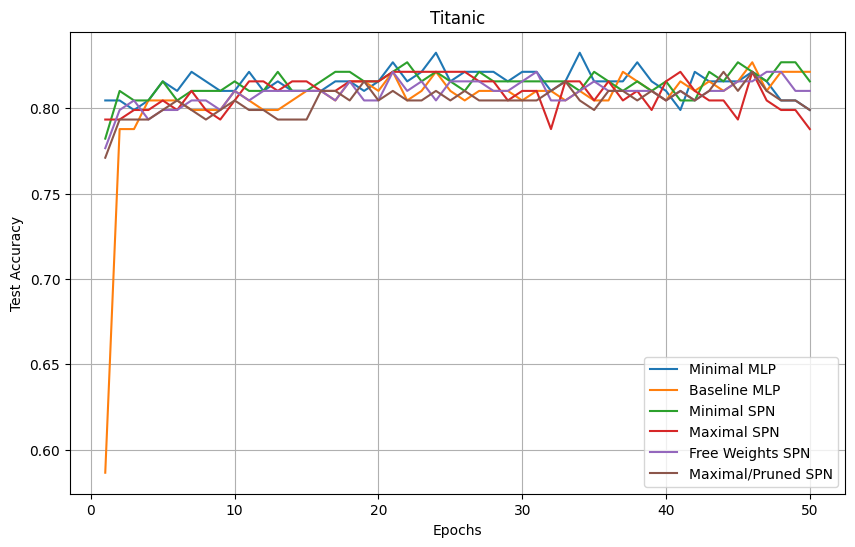

In [37]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, test_acc_0, label='Minimal MLP')
plt.plot(epochs, test_acc_1, label='Baseline MLP')
plt.plot(epochs, test_acc_2, label='Minimal SPN')
plt.plot(epochs, test_acc_3, label='Maximal SPN')
plt.plot(epochs, test_acc_4, label='Free Weights SPN')
plt.plot(epochs, test_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Titanic')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/Titanic/test_accuracy_plot.png')  # Save as PNG file
plt.show()

Get efficiency of each model

In [38]:
# List of all test accuracies
test_accuracies = [test_acc_0, test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5]

# Find the index of the best (maximum) accuracy for each model
best_accuracy_indices = [np.argmax(acc) + 1 for acc in test_accuracies]

In [39]:
time_to_best_acc_0 = train_metrics_0[:best_accuracy_indices[0], 0].sum()
time_to_best_acc_1 = train_metrics_1[:best_accuracy_indices[1], 0].sum()
time_to_best_acc_2 = train_metrics_2[:best_accuracy_indices[2], 0].sum()
time_to_best_acc_3 = train_metrics_3[:best_accuracy_indices[3], 0].sum()
time_to_best_acc_4 = train_metrics_4[:best_accuracy_indices[4], 0].sum()
time_to_best_acc_5 = train_metrics_5[:best_accuracy_indices[5], 0].sum()

best_test_acc_0 = test_acc_0[best_accuracy_indices[0] - 1]
best_test_acc_1 = test_acc_1[best_accuracy_indices[1] - 1]
best_test_acc_2 = test_acc_2[best_accuracy_indices[2] - 1]
best_test_acc_3 = test_acc_3[best_accuracy_indices[3] - 1]
best_test_acc_4 = test_acc_4[best_accuracy_indices[4] - 1]
best_test_acc_5 = test_acc_5[best_accuracy_indices[5] - 1]

In [40]:
summary_0 = ['Minimal MLP', param_count_0, best_test_acc_0, time_to_best_acc_0, best_test_acc_0 / time_to_best_acc_0]
summary_1 = ['Baseline MLP', param_count_1, best_test_acc_1, time_to_best_acc_1, best_test_acc_1 / time_to_best_acc_1]
summary_2 = ['Minimal SPN', param_count_2, best_test_acc_2, time_to_best_acc_2, best_test_acc_2 / time_to_best_acc_2]
summary_3 = ['Maximal SPN', param_count_3, best_test_acc_3, time_to_best_acc_3, best_test_acc_3 / time_to_best_acc_3]
summary_4 = ['Free Weights SPN', param_count_4, best_test_acc_4, time_to_best_acc_4, best_test_acc_4 / time_to_best_acc_4]
summary_5 = ['Maximal/Pruned SPN', param_count_5, best_test_acc_5, time_to_best_acc_5, best_test_acc_5 / time_to_best_acc_5]

In [45]:
import pandas as pd

# Combine all summaries into a list of lists (each summary as a row)
summaries = [summary_0, summary_1, summary_2, summary_3, summary_4, summary_5]

# Create a DataFrame
df = pd.DataFrame(summaries, columns=['Model', 'Parameter Count', 'Best Test Accuracy', 'Time to Best Test Accuracy', 'Efficiency'])

# Set the display options to allow for better fitting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the width so it can fit more columns
pd.set_option('display.max_colwidth', None)  # Allow unlimited column width

# Now when you print the DataFrame, it will be displayed as a continuous table
print(df)

                Model  Parameter Count  Best Test Accuracy  Time to Best Test Accuracy  Efficiency
0         Minimal MLP             1058            0.832402                    0.300853    2.766805
1        Baseline MLP             2722            0.826816                    0.676673    1.221884
2         Minimal SPN             1074            0.826816                    0.286312    2.887812
3         Maximal SPN             5635            0.821229                    7.872650    0.104314
4    Free Weights SPN             3122            0.821229                    0.438577    1.872487
5  Maximal/Pruned SPN               40            0.821229                    0.701506    1.170666


In [42]:
df.to_csv('results/Titanic/model_summary.csv', index=False)